In [1]:
using LinearAlgebra, Random, Statistics, Plots
# read data 
using MLDatasets, ImageCore

## Loading data

Let's load in the data, and transform the ys into usable psi's for multiclass classification.

In [2]:
Xtrain, ytrain = MNIST.traindata()
Xtest,  ytest  = MNIST.testdata()

Xtrain = MNIST.convert2features(Xtrain)'
Xtest = MNIST.convert2features(Xtest)'

10000×784 Adjoint{Normed{UInt8,8},Base.ReshapedArray{Normed{UInt8,8},2,Base.ReinterpretArray{Normed{UInt8,8},3,UInt8,Array{UInt8,3}},Tuple{}}}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [3]:
function convert2psi(ys, n = 10)
    psis = -1.0*ones(length(ys), n)
    for i in 1:length(ys)
        psis[i, ys[i] + 1] = 1.0
    end
    return psis
end

psiTrain = convert2psi(ytrain)
psiTest = convert2psi(ytest)

10000×10 Array{Float64,2}:
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0
 -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
  1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0
 -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0
  1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0
  ⋮                             ⋮                          
 -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  

## Function Definitions

Here, let's put most of the functions we'll need for both the forward and the backward passes.

We'll need several different types of losses, and we need data transformations like "ReLU" and "softmax."

For everything, we will also code up an explicit derivative, for the backward pass.

In [55]:
function softmax(l)
    L = exp.(l)
    s = sum(L, dims = 2)
    return L./s
end

function logisticLoss(ys, preds)
    return log.(exp.(-ys.*preds).+ 1)
end

function l2Loss(ys, preds)
    return (preds - ys).^2
end

function l1Loss(ys, preds)
    return abs.(preds - ys)
end

ReLU(x) = max(x, 0)
function hinge(ys, preds)
    return ReLU.((-ys.*preds).+1)
end

hinge (generic function with 1 method)

In [56]:
function logisticDerivative(ys, preds)
    exps = exp.(-ys.*preds)
    (-ys.*exps)./(exps.+1)
end

function l2derivative(ys, preds)
    return (preds - ys).*2
end

function l1derivative(ys, preds)
    return sign.(preds - ys)
end

function hingeDerivative(ys, preds)
    return sign.(hinge(ys, preds)).*(-ys)
end

function ReLUDerivative(vals)
    return 0.5 + 0.5.*sign.(vals)
end

ReLUDerivative (generic function with 1 method)

In [6]:
function predictedClass(preds)
    _, h = findmax(preds, dims=2)
    ypred = [element[2] - 1 for element in h]
    return ypred
end

function accuracy(y, ypred)
    # Unlike the other losses, this one takes the actual class labels as input, not the transformed inputs (psis)
    return sum(y.==ypred)/length(y)
end

accuracy (generic function with 1 method)

In [11]:
function linDerivatives(X, outDers)
    bDer = zeros(size(outDers)[2])
    WDer = zeros(size(outDers)[2]).*transpose(zeros(size(X)[2]))
    for i in 1:(size(X)[1])
        bDer += outDers[i, :]
        WDer += outDers[i, :].*transpose(X[i, :])
    end
    return WDer, bDer
end

function inputDerivatives(W, outDers)
    return transpose(tranpose(W)*transpose(outDers))
end

inputDerivatives (generic function with 1 method)

## Testing

We're going to test our functions, and walk through a typical forward and backward pass.

Let's start by testing out softmax and our ability to test derivatives, as well as look at the accuracy at initialization.

We won't use softmax for the first classifier we try, but it is a useful tool, as we will see later.

In [10]:
a = randn(100, 10)
#print(a)
t = (softmax(a).*2.0).-1
println("\nSoftmax-derived values")
println(t)
println("\nSums of rows. Should be -8; 1*2 - 1")
println(sum(t, dims=2))
losses = l2Loss(psiTrain[1:100, :], t)
outDers = l2derivative(psiTrain[1:100, :], t)

aDers = outDers.*softMaxDerivative(a).*2
println("\nComputed derivatives")
println(aDers)
println("\nAccuracy:")
println(accuracy(ytrain[1:100], predictedClass(t)))


Softmax-derived values


[-0.786758 -0.617184 -0.95168 -0.564659 -0.908559 -0.804684 -0.800519 -0.839237 -0.934369 -0.79235; -0.795398 -0.64005 -0.860298 -0.84412 -0.760828 -0.922517 -0.821541 -0.785929 -0.730091 -0.839227; -0.916255 -0.549575 -0.820586 -0.733325 -0.808999 -0.945912 -0.93567 -0.802908 -0.560864 -0.925906; -0.946821 -0.908303 -0.967749 -0.911289 -0.958903 -0.266476 -0.978235 -0.760654 -0.367207 -0.934362; -0.923551 -0.909515 -0.803462 -0.821551 -0.849744 -0.852483 -0.634708 -0.780674 -0.861385 -0.562928; -0.839457 -0.854107 -0.985776 -0.762554 -0.860788 -0.431547 -0.849115 -0.952709 -0.611309 -0.852637; -0.842236 -0.910813 -0.916486 -0.744174 -0.37848 -0.7627 -0.788867 -0.953844 -0.88785 -0.81455; -0.580841 -0.978953 -0.933275 -0.799658 -0.75131 -0.554334 -0.84623 -0.878807 -0.781466 -0.895127; -0.318507 -0.628294 -0.909543 -0.944272 -0.592123 -0.979815 -0.939325 -0.950326 -0.945074 -0.792722; -0.720818 -0.481438 -0.518101 -0.829061 -0.863842 -0.935709 -0.933746 -0.813967 -0.982415 -0.920903; -

[0.081248 0.236995 0.00455675 0.296537 0.0159584 -0.636121 0.0716472 0.0475349 0.00833203 0.0772833; -0.659526 0.212491 0.0363067 0.0448092 0.100725 0.011542 0.0580118 0.0818426 0.126038 0.0475403; 0.0134392 0.314383 0.0586033 0.123266 -0.625046 0.00569285 0.00801046 0.0700345 0.300997 0.0105731; 0.00550561 -0.333926 0.00204665 0.015041 0.00330846 0.681437 0.000937127 0.100862 0.547466 0.0083339; 0.0112422 0.0156343 0.0696624 0.0580058 0.0417615 0.0403124 0.218133 0.0856575 0.0357649 -1.06765; 0.0474105 0.0394642 -0.0560899 0.0993738 0.036062 0.462588 0.0420973 0.00436706 0.243437 0.0402314; 0.0458525 -0.32564 0.0133668 0.114151 0.532489 0.0992599 0.0797429 0.00416239 0.0237445 0.0624056; 0.277744 0.000876606 0.0086074 -0.648861 0.108313 0.308719 0.0436547 0.0275957 0.0850778 0.0208434; 0.612358 -0.98552 0.0156247 0.00603818 0.264872 0.000806656 0.00713958 0.00481245 0.00586801 0.0770229; 0.134125 0.398368 0.352543 0.0534453 -0.473001 0.00800086 0.00848842 0.0627782 0.000613035 0.01201

 -0.681504 0.227167; 0.0317021 0.1071 0.00179524 -0.563697 0.0950002 0.00559113 0.096515 0.0263059 0.676224 0.00642383; 0.317238 -0.679682 0.0255131 0.0692002 0.0454575 0.0510961 0.0734051 0.0145195 0.186092 0.0107526]

Accuracy:
0.12


Let's initialize our linear parameters and bias terms.

In [13]:
d = size(Xtrain)[2]
k = size(psiTrain)[2]

W = randn(d, k)./(d^0.5) #Useful regularization to make the sum in the ballpark of 1.0
b = randn(k)

10-element Array{Float64,1}:
  0.5902518717767695 
  0.6175006124895448 
  0.9308521405765469 
 -0.668351189459452  
 -1.621252741885368  
 -0.10206348935225011
  0.1598824243827818 
  0.2575900225229577 
  0.46579169079671434
  0.5590721156787988 

Next, let's compute the predicted values. For the simplest model, we won't even bother with a softmax layer; we'll just fit a linear classifier.

In [14]:
preds = Xtrain*W.+transpose(b)

60000×10 Array{Float64,2}:
 0.627536  0.0896949  0.947931  …   0.0229407    0.421983   0.0695992
 0.901299  0.127454   0.698638     -0.522017     0.660196   0.0985156
 0.520063  0.444477   1.06362       0.401561     0.668733   0.402096 
 0.590596  0.577284   0.912494      0.0129854    0.51533    0.527577 
 1.1306    0.726546   0.707155      0.056967     0.682464   0.453848 
 1.07468   0.107317   1.04285   …  -0.171501     0.515066  -0.113045 
 0.700486  0.0931014  1.06575      -0.101769     0.683414   0.615047 
 0.696808  0.521374   0.845642     -0.0155327    0.588312  -0.0568879
 0.600712  0.558696   0.900776     -0.255877     0.545187   0.528843 
 0.600838  0.535107   0.894372     -0.0134501    0.412428   0.0498801
 0.746512  0.422325   0.763093  …  -0.477915     0.818453   0.233459 
 0.818353  0.542573   0.804484      0.0145489    0.32944    0.515748 
 0.237501  0.401295   0.760597     -0.479393     0.669958   0.718659 
 ⋮                              ⋱                              

Next, let's compute the loss.

In [17]:
Losses = l2Loss(psiTrain, preds)
L = sum(Losses)
println(L)

println(accuracy(ytrain[1:100], predictedClass(t)))

970405.284004491
0.12


Because the total loss is just the sum of the individual losses, the partial derivative of $L$ with respect to every element of $Losses$ is just $1$. So, we don't need to be careful when we compute the derivatives of the losses with respect to the outputs of our linear transformation.

In [16]:
outDers = l2derivative(psiTrain, preds)

60000×10 Array{Float64,2}:
  3.25507    2.17939    3.89586    …   2.04588    2.84397    2.1392 
 -0.197401   2.25491    3.39728        0.955966   3.32039    2.19703
  3.04013    2.88895    4.12723        2.80312    3.33747    2.80419
  3.18119   -0.845432   3.82499        2.02597    3.03066    3.05515
  4.2612     3.45309    3.41431        2.11393    3.36493   -1.0923 
  4.14936    2.21463    0.0857027  …   1.657      3.03013    1.77391
  3.40097   -1.8138     4.1315         1.79646    3.36683    3.23009
  3.39362    3.04275    3.69128        1.96893    3.17662    1.88622
  3.20142   -0.882609   3.80155        1.48825    3.09037    3.05769
  3.20168    3.07021    3.78874        1.9731     2.82486    2.09976
  3.49302    2.84465    3.52619    …   1.04417    3.63691    2.46692
  3.63671    3.08515    3.60897        2.0291     2.65888    3.0315 
  2.475      2.80259    3.52119        1.04121    3.33992    3.43732
  ⋮                                ⋱                                
  2.544

Finally, we use those output derivatives to compute the derivatives with respect to the paramaters of the linear classifier.

In [19]:
Wder, bder = linDerivatives(Xtrain, outDers)
#Wder

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [1.77952e5, 1.31013e5, 187399.0, -15298.4, -1.01208e5, 63893.3, 1.30678e5, 92989.9, 1.77738e5, 1.30837e5])

I threw together a gradient descent algorithm. Basically, it takes a step that is expected to produce an $\epsilon$ fraction reduction in the loss, where $\epsilon$ defaults to $0.01$. I also added some steps to avoid numerical instability.

Usually, one would use an out-of-the-box solver at this stage, like SGD or Adam.

In [20]:
function layer1step(Loss, W, b, Wder, bder, eps = 0.01)
    targetChange = eps*Loss
    expectedChange = sum(bder.^2) + sum(Wder.^2) + 1.0
    r = min(abs(targetChange/expectedChange), 1)
    #println(r)
    return W - transpose(Wder).*r, b - bder.*r
end
W, b = layer1step(L, W, b, Wder, bder)

([-0.0847992 -0.000794762 … 0.000783554 0.0458274; -0.0154678 -0.0429908 … -0.0177501 0.0208172; … ; 0.0203827 -0.0226313 … 0.00741309 -0.0325672; 0.0407847 -0.0110487 … -0.0299164 -0.0315766], [0.589973, 0.617295, 0.930558, -0.668327, -1.62109, -0.102164, 0.159678, 0.257444, 0.465513, 0.558867])

## Simple, Linear Classifier

Now that we have all the tools, let's fit just a simple linear classifier with $L2$ loss, and see what the end accuracy is.

In [36]:
Ls = zeros(100)
accsTrain = zeros(100)
accsTest = zeros(100)

for i in 1:100
    preds = Xtrain*W.+transpose(b)
    Losses = l2Loss(psiTrain, preds)
    L = sum(Losses)
    Ls[i] = L
    accTrain = accuracy(ytrain, predictedClass(preds))
    accsTrain[i] = accTrain
    accTest = accuracy(ytest, predictedClass(Xtest*W.+transpose(b)))
    accsTest[i] = accTest
    println("\n\nIteration")
    println(i)
    println("Loss")
    println(L)
    println("Train Accuracy")
    println(accTrain)
    println("Test Accuracy")
    println(accTest)
    outDers = l2derivative(psiTrain, preds)
    Wder, bder = linDerivatives(Xtrain, outDers)
    W, b = layer1step(L, W, b, Wder, bder, 0.1)
end



Iteration
1
Loss
868158.9943218518
Train Accuracy
0.12373333333333333
Test Accuracy
0.1264


Iteration
2
Loss
784657.0046651221
Train Accuracy
0.12483333333333334
Test Accuracy
0.1275


Iteration
3
Loss
709356.4966890309
Train Accuracy
0.12646666666666667
Test Accuracy
0.1286


Iteration
4
Loss
641472.2222275218
Train Accuracy
0.12901666666666667
Test Accuracy
0.1297


Iteration
5
Loss
580300.5692692224
Train Accuracy
0.13201666666666667
Test Accuracy
0.1328


Iteration
6
Loss
525214.2344530383
Train Accuracy
0.1356
Test Accuracy
0.1361


Iteration
7
Loss
475659.32755291864
Train Accuracy
0.14101666666666668
Test Accuracy
0.1419


Iteration
8
Loss
431156.5603588723
Train Accuracy
0.14808333333333334
Test Accuracy
0.1463


Iteration
9
Loss
391310.5017697086
Train Accuracy
0.15605
Test Accuracy
0.1523


Iteration
10
Loss
355837.2557592962
Train Accuracy
0.16435
Test Accuracy
0.1635


Iteration
11
Loss
324639.61966940074
Train Accuracy
0.1744
Test Accuracy
0.1715


Iteration
12
Loss
298



Iteration
94
Loss
120121.67677472497
Train Accuracy
0.8197666666666666
Test Accuracy
0.8325


Iteration
95
Loss
209016.97193061793
Train Accuracy
0.7156333333333333
Test Accuracy
0.7118


Iteration
96
Loss
189321.56964146823
Train Accuracy
0.7381166666666666
Test Accuracy
0.7372


Iteration
97
Loss
171654.0778696579
Train Accuracy
0.7587333333333334
Test Accuracy
0.7599


Iteration
98
Loss
155873.43217143542
Train Accuracy
0.7775
Test Accuracy
0.7757


Iteration
99
Loss
141909.0959185672
Train Accuracy
0.79455
Test Accuracy
0.7954


Iteration
100
Loss
129862.8795708684
Train Accuracy
0.8088666666666666
Test Accuracy
0.8127


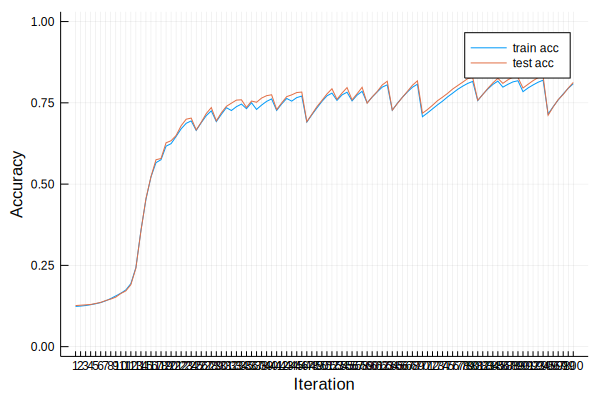

In [37]:
plot([i for i in 1:100], hcat(accsTrain, accsTest), xaxis = ("Iteration", 1:100), yaxis = ("Accuracy", 0:1), label = ["train acc", "test acc"])

In [38]:
println("Max train accuracy")
println(findmax(accsTrain))
println("Max test accuracy")
println(findmax(accsTest))

Max train accuracy
(0.8197666666666666, 94)
Max test accuracy
(0.8325, 94)


Because we are using such a simple model, we never had a chance to overfit; the end test accuracy is actually slightly higher than the train accuracy.

This also shows why MNIST is considered a rudimentary computer vision problem: even a linear classifier can get a fairly high accuracy.

Despite all this, lets see how much we can improve these results. What happens if, instead of the less-than-perfect L2 loss, we use a loss more fitting to the problem, such as hinge loss? After all, a label above $1$ or below $-1$ should be unambiguous.

## Hinge Loss

In [39]:
W = randn(d, k)./(d^0.5)
b = randn(k)

Ls = zeros(100)
accsTrain = zeros(100)
accsTest = zeros(100)

100-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [47]:
for i in 1:100
    preds = Xtrain*W.+transpose(b)
    Losses = hinge(psiTrain, preds)
    L = sum(Losses)
    Ls[i] = L
    accTrain = accuracy(ytrain, predictedClass(preds))
    accsTrain[i] = accTrain
    accTest = accuracy(ytest, predictedClass(Xtest*W.+transpose(b)))
    accsTest[i] = accTest
    println("\n\nIteration")
    println(i)
    println("Loss")
    println(L)
    println("Train Accuracy")
    println(accTrain)
    println("Test Accuracy")
    println(accTest)
    outDers = hingeDerivative(psiTrain, preds)
    Wder, bder = linDerivatives(Xtrain, outDers)
    W, b = layer1step(L, W, b, Wder, bder, 0.1)
end



Iteration
1
Loss
756886.6522481532
Train Accuracy
0.10035
Test Accuracy
0.1063


Iteration
2
Loss
681397.3594242311
Train Accuracy
0.10068333333333333
Test Accuracy
0.1065


Iteration
3
Loss
613727.3780578412
Train Accuracy
0.10106666666666667
Test Accuracy
0.1072


Iteration
4
Loss
553225.8218696779
Train Accuracy
0.1015
Test Accuracy
0.1075


Iteration
5
Loss
499186.51967455004
Train Accuracy
0.10193333333333333
Test Accuracy
0.1078


Iteration
6
Loss
450750.8959920022
Train Accuracy
0.10245
Test Accuracy
0.1086


Iteration
7
Loss
407184.2632768685
Train Accuracy
0.10301666666666667
Test Accuracy
0.1099


Iteration
8
Loss
368020.6888258563
Train Accuracy
0.10386666666666666
Test Accuracy
0.1104


Iteration
9
Loss
332934.56716950255
Train Accuracy
0.10428333333333334
Test Accuracy
0.1116


Iteration
10
Loss
301433.0766770534
Train Accuracy
0.10555
Test Accuracy
0.1133


Iteration
11
Loss
273027.8652052458
Train Accuracy
0.10815
Test Accuracy
0.1158


Iteration
12
Loss
247461.5470669



Iteration
94
Loss
98362.56497004477
Train Accuracy
0.7564666666666666
Test Accuracy
0.7604


Iteration
95
Loss
88845.12825366229
Train Accuracy
0.7832333333333333
Test Accuracy
0.7913


Iteration
96
Loss
80301.44219899137
Train Accuracy
0.80735
Test Accuracy
0.8147


Iteration
97
Loss
72658.70933696096
Train Accuracy
0.8264833333333333
Test Accuracy
0.8353


Iteration
98
Loss
65842.40578900129
Train Accuracy
0.8436
Test Accuracy
0.8498


Iteration
99
Loss
59765.75485397903
Train Accuracy
0.8593333333333333
Test Accuracy
0.8652


Iteration
100
Loss
54427.16412282566
Train Accuracy
0.8707666666666667
Test Accuracy
0.8774


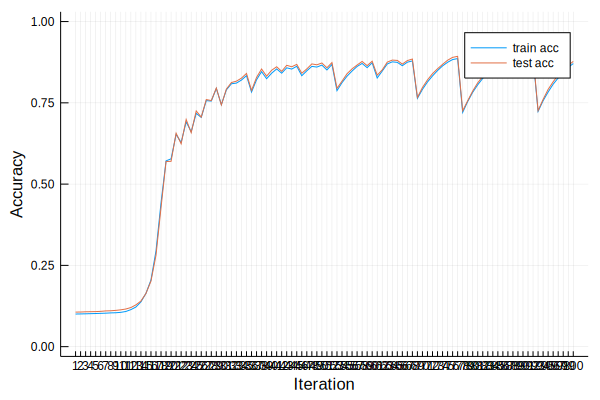

In [48]:
plot([i for i in 1:100], hcat(accsTrain, accsTest), xaxis = ("Iteration", 1:100), yaxis = ("Accuracy", 0:1), label = ["train acc", "test acc"])

In [49]:
println("Max train accuracy")
println(findmax(accsTrain))
println("Max test accuracy")
println(findmax(accsTest))

Max train accuracy
(0.8891833333333333, 92)
Max test accuracy
(0.8962, 92)


There seems to be a substantial improvement!

## Logistic Loss

Let's try a nonlinear function that is more expressive, and has a chance to give our model even more flexibility.

In [51]:
W = randn(d, k)./(d^0.5)
b = randn(k)

Ls = zeros(100)
accsTrain = zeros(100)
accsTest = zeros(100)

100-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [58]:
for i in 1:100
    preds = Xtrain*W.+transpose(b)
    Losses = logisticLoss(psiTrain, preds)
    L = sum(Losses)
    Ls[i] = L
    accTrain = accuracy(ytrain, predictedClass(preds))
    accsTrain[i] = accTrain
    accTest = accuracy(ytest, predictedClass(Xtest*W.+transpose(b)))
    accsTest[i] = accTest
    println("\n\nIteration")
    println(i)
    println("Loss")
    println(L)
    println("Train Accuracy")
    println(accTrain)
    println("Test Accuracy")
    println(accTest)
    outDers = logisticDerivative(psiTrain, preds)
    Wder, bder = linDerivatives(Xtrain, outDers)
    W, b = layer1step(L, W, b, Wder, bder, 0.1)
end



Iteration
1
Loss
571752.1032463885
Train Accuracy
0.0834
Test Accuracy
0.0887


Iteration
2
Loss
516778.69020146935
Train Accuracy
0.0849
Test Accuracy
0.0892


Iteration
3
Loss
467355.68275421346
Train Accuracy
0.08701666666666667
Test Accuracy
0.0908


Iteration
4
Loss
422939.8836219865
Train Accuracy
0.08935
Test Accuracy
0.0929


Iteration
5
Loss
383044.7816057309
Train Accuracy
0.0939
Test Accuracy
0.0976


Iteration
6
Loss
347235.7716856393
Train Accuracy
0.09973333333333333
Test Accuracy
0.1041


Iteration
7
Loss
315128.7693186351
Train Accuracy
0.1081
Test Accuracy
0.1113


Iteration
8
Loss
286392.77033830713
Train Accuracy
0.11885
Test Accuracy
0.1207


Iteration
9
Loss
260756.53877424414
Train Accuracy
0.14175
Test Accuracy
0.1417


Iteration
10
Loss
238018.16698401677
Train Accuracy
0.18251666666666666
Test Accuracy
0.1814


Iteration
11
Loss
218037.09859778214
Train Accuracy
0.2462
Test Accuracy
0.2402


Iteration
12
Loss
200521.357326646
Train Accuracy
0.3440166666666667

Iteration
94
Loss
138294.61171421612
Train Accuracy
0.6652333333333333
Test Accuracy
0.668


Iteration
95
Loss
124989.50392599241
Train Accuracy
0.6977166666666667
Test Accuracy
0.7013


Iteration
96
Loss
113023.67293939854
Train Accuracy
0.7278333333333333
Test Accuracy
0.7313


Iteration
97
Loss
102264.97825819218
Train Accuracy
0.7542166666666666
Test Accuracy
0.7596


Iteration
98
Loss
92596.25811022747
Train Accuracy
0.7784333333333333
Test Accuracy
0.785


Iteration
99
Loss
83914.52272202623
Train Accuracy
0.8013
Test Accuracy
0.8103


Iteration
100
Loss
76131.19676713194
Train Accuracy
0.8209166666666666
Test Accuracy
0.8298


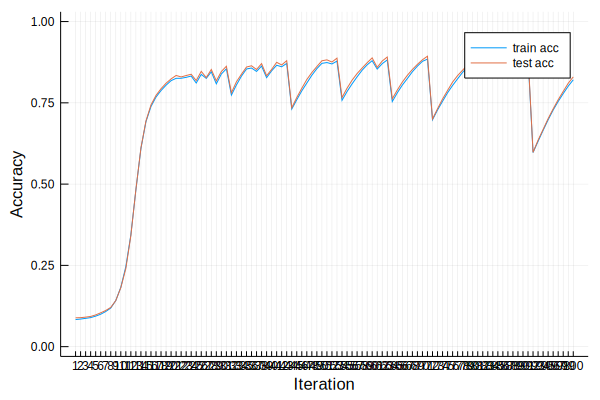

In [59]:
plot([i for i in 1:100], hcat(accsTrain, accsTest), xaxis = ("Iteration", 1:100), yaxis = ("Accuracy", 0:1), label = ["train acc", "test acc"])

In [60]:
println("Max train accuracy")
println(findmax(accsTrain))
println("Max test accuracy")
println(findmax(accsTest))

Max train accuracy
(0.8902833333333333, 91)
Max test accuracy
(0.8994, 91)
